# Web Data Scraping

[Spring 2023 ITSS Mini-Course](https://www.colorado.edu/cartss/programs/interdisciplinary-training-social-sciences-itss/mini-course-web-data-scraping) — ARSC 5040  
[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

These notebooks are adaptations from a 5 session mini course at the University of Colorado. The github repo can be found here [Spring 2023 ITSS Mini-Course] The course is taught by Brian C. Keegan, Ph.D. Assistant Professor, Department of Information Science. They have been adapted for relevant content and integration with Docker so that we all have the same environment. Professor Keegan suggests using a most recent version of Python which we have through our docker container.

This notebook is adapted from excellent notebooks in Dr. Cody Buntain's seminar on Social Media and Crisis Informatics as well as the PRAW documentation.

We'll need a few common libraries for all these examples.

In [1]:
# Lets us talk to other servers on the web
import requests

# APIs spit out data in JSON
import json

# Use BeautifulSoup to parse some HTML
from bs4 import BeautifulSoup

# Handling dates and times
from datetime import datetime

# DataFrames!
import pandas as pd
import numpy as np

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Scraping Reddit

Reddit also hosts a lot of detailed behavioral data that could be of interest to social scientists. As was the case with Wikipedia, our naïve inclination may be to develop scrapers and parsers to extract this information, but Reddit will give much of it to you for free through their API!

You can retrieve a few different types of entities from Reddit's API: sub-reddits, submissions, comments, and redditors. Many of these are interoperable: a sub-reddit contains submissions contributed by redditors with comments from other redditors.

We will use a wrapper library to communicate with the Reddit API called [Python Reddit API Wrapper](https://praw.readthedocs.io/en/latest/) or `praw`. 

Copy the code below to your terminal to install `praw`.

Afterwards, we can import `praw`.

In [2]:
import praw

We then need to authenticate with Reddit to get access to the API. Typically you can just enter the client ID, client secret, password, username, *etc*. as strings. 

1. You will need to create an account on Reddit. After you have created an account and logged in, go to https://www.reddit.com/prefs/apps/. 
2. Scroll down and click the "create app" button at the bottom. Provide a basic name, description, and enter a URL for your homepage (or just use http://www.ucla.edu).
3. You will need the client ID (the string of characters beneath the name of your app) as well as the secret (the other string of characters) as well as your username and password.
4. You can make up a user-agent string, but include your username as good practice for the sysadmins to track you down if you break things.


You'll create an API connector object (`r`) below that will authenticate with the API and handle making the requests.

In [3]:
#r = praw.Reddit(
#    client_id='your application id',
#    client_secret='your application secret',
#    password='your account password',
#    user_agent='scraping script by /u/youraccountname',
#    username='your account name'
#)

You can confirm that this authentication process worked by making a simple request like printing your username.

In [4]:
#print(r.user.me())

I'm going to read them in from a local file ("login.json") so that I post this notebook on the internet in the future without compromising my account security. This won't work for you, so just skip this step.

In [3]:
# Load my credentials from a local disk so I don't show the world
with open('reddit_login.json','r') as f:
    r_creds = json.load(f)
    
# Create an authenticated reddit instance using the creds
r = praw.Reddit(client_id = r_creds['client_id'],
                client_secret = r_creds['client_secret'],
                password = r_creds['password'],
                user_agent = r_creds['user_agent'],
                username = r_creds['username'])

# Make sure your reddit instance works
print(r.user.me())

langholz-stat


### Sub-reddits
Now print the top 25 stories in /r/news.

[Documentation for the Subreddit model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html).

Create a `news_subreddit` object to store the various attributes about this sub-reddit.

In [4]:
news_subreddit = r.subreddit('news')

The `news_subreddit` has a number of attributes and methods you can call on it. The time the sub-reddit was founded.

In [5]:
news_subreddit.created_utc

1201243765.0

That's formatted in a UNIX timecode (seconds since 1 January 1970), but we can convert it into a more readable timestamp with `datetime`'s `utcfromtimestamp`.

In [6]:
print(datetime.utcfromtimestamp(news_subreddit.created_utc))

2008-01-25 06:49:25


/tmp/ipykernel_563/2989456704.py:1: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print(datetime.utcfromtimestamp(news_subreddit.created_utc))


There are other attributes such as the number of subscribers, current active users, as well as the description of the sub-reddit.

In [7]:
'{0:,}'.format(news_subreddit.subscribers)

'30,087,099'

In [8]:
news_subreddit.over18

False

In [9]:
news_subreddit.active_user_count

5404

In [10]:
print(news_subreddit.description)

>* **[/r/worldnews](/r/worldnews?hl)**

>#

>* **[/r/politics](/r/politics?hl)**

>#

>* **[/r/Foodforthought](/r/Foodforthought?hl)**

---

See a post that violates the rules below? Did your post get stuck in the spam filter? Have a question about the rules? Just want to give feedback? [Send the mod team a message](http://www.reddit.com/message/compose?to=%2Fr%2Fnews).

---

**Your account must be email-verified to participate in /r/news.**

---

**Your post will be removed if it:** 

* is not news.
* is not in English.
* is an opinion/analysis or advocacy piece.
* primarily concerns politics.
* has a title that does not match the actual title or [the lede](https://www.merriam-webster.com/dictionary/lede "the introductory section of a news story that is intended to entice the reader to read the full story").
* has a pay wall or steals content.
* covers an already-submitted story.
* violates [reddit's site-wide rules](http://www.reddit.com/rules/ "Reddit Content Policy"), especially re

The rules of the sub-reddit are available as a method `.rules()` which returns a list of dictionaries of rule objects.

In [11]:
news_subreddit.rules()['rules']

/tmp/ipykernel_563/2202060975.py:1: DeprecationWarning: Calling SubredditRules to get a list of rules is deprecated. Remove the parentheses to use the iterator. View the PRAW documentation on how to change the code in order to use the iterator (https://praw.readthedocs.io/en/latest/code_overview/other/subredditrules.html#praw.models.reddit.rules.SubredditRules.__call__).
  news_subreddit.rules()['rules']


[{'kind': 'link',
  'description': 'A story that does not properly report a story, or is not noteworthy, or is not in English. Self-posts and meta-posts without moderator approval (live update threads, major breaking news, and megathreads are usually exempt) are not allowed. Articles must be about a specific news event.',
  'short_name': 'Submissions must be articles about a specific news event',
  'violation_reason': 'Submissions must be articles about a specific news event',
  'created_utc': 1652980697,
  'priority': 0,
  'description_html': '<!-- SC_OFF --><div class="md"><p>A story that does not properly report a story, or is not noteworthy, or is not in English. Self-posts and meta-posts without moderator approval (live update threads, major breaking news, and megathreads are usually exempt) are not allowed. Articles must be about a specific news event.</p>\n</div><!-- SC_ON -->'},
 {'kind': 'link',
  'description': ' News articles must be covering recent events, which for our pur

When were each of these rules created? Loop through each of the rules and print the "short_name" of the rule and the rule timestamp.

In [12]:
for rule in news_subreddit.rules()['rules']:
    created = rule['created_utc']
    print(rule['short_name'], datetime.utcfromtimestamp(created))

Submissions must be articles about a specific news event 2022-05-19 17:18:17
Old News 2025-04-22 17:49:13
No opinion/analysis or advocacy pieces 2022-05-19 17:18:17
Articles must not be primarily concerning politics 2022-05-19 17:18:17
No editorialized titles; Title must match article title 2022-05-19 17:18:17
No paywalls/blogspam that steals content 2022-05-19 17:18:17
No posts covering an already submitted story 2022-05-19 17:18:17
Do not be racist, sexist, vitriolic, or overly crude 2022-05-19 17:18:17
Do not be unnecessarily rude or provocative 2022-05-19 17:18:17
No cheap or distracting jokes or memes 2022-05-19 17:18:17
No witchhunting. Follow the Reddit Content Policy. 2022-05-19 17:18:17
Do not advocate or celebrate death 2022-05-19 17:18:17
No bots/Novelty accounts 2022-05-19 17:18:17


/tmp/ipykernel_563/2597324410.py:1: DeprecationWarning: Calling SubredditRules to get a list of rules is deprecated. Remove the parentheses to use the iterator. View the PRAW documentation on how to change the code in order to use the iterator (https://praw.readthedocs.io/en/latest/code_overview/other/subredditrules.html#praw.models.reddit.rules.SubredditRules.__call__).
  for rule in news_subreddit.rules()['rules']:
/tmp/ipykernel_563/2597324410.py:3: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print(rule['short_name'], datetime.utcfromtimestamp(created))


We can also get a list of the moderators for this subreddit.

In [13]:
mod_list = []

for mod in news_subreddit.moderator():
    mod_list.append(mod.name)
    
mod_list

['Elderthedog',
 'ani625',
 'hoosakiwi',
 'DiggDejected',
 'todayilearned83',
 'gutpocketsucks',
 'ReganDryke',
 'pussgurka',
 'AudibleNod',
 'Plainchant',
 'lolihull',
 'Vfef',
 'fingerpaintswithpoop',
 'NewsModTeam',
 'Superbuddhapunk',
 'dieyoufool3',
 'GeauxTheFckAway',
 '-doughboy',
 'comment-nuke']

### Submissions

We can get a list of submissions to a sub-reddit using [a few different methods](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html).

* `.controversial()`
* `.hot()`
* `.new()`
* `.rising()`
* `.search()`
* `.top()`

Here we will use the `.top()` method to get the top 25 submissions on the /r/news subreddit from the past 12 months.

[Documentation for the Submission model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html).

In [14]:
top25_news = r.subreddit('news').top(time_filter = 'year',limit=25)

`top25_news` is a `ListingGenerator` object, which is a special [generator](https://www.dataquest.io/blog/python-generators-tutorial/) class defined by PRAW. It does not actually go out and get the data at this stage. There's not much you can do to look inside this `ListingGenerator` other than loop through and perform operations. In this case, lets add each submission to a list of `top25_submissions`.

In [15]:
top25_submissions = []

for submission in r.subreddit('news').top(time_filter = 'year',limit=25):
    top25_submissions.append(submission)

We can inspect the first (top) `Submission` object.

In [16]:
first_submission = top25_submissions[0]
first_submission

Submission(id='1e8s7cm')

Use the `dir` function to see the other methods and attributes inside this first top `Submission` object. (There are a lot of other "hidden" attributes and methods that use the "\_" which we can ignore with this list comprehension.)

In [17]:
[i for i in dir(first_submission) if '_' not in i]

['archived',
 'author',
 'award',
 'awarders',
 'category',
 'clicked',
 'comments',
 'created',
 'crosspost',
 'delete',
 'distinguished',
 'domain',
 'downs',
 'downvote',
 'duplicates',
 'edit',
 'edited',
 'flair',
 'fullname',
 'gild',
 'gilded',
 'gildings',
 'hidden',
 'hide',
 'id',
 'likes',
 'locked',
 'media',
 'mod',
 'name',
 'parse',
 'permalink',
 'pinned',
 'pwls',
 'quarantine',
 'reply',
 'report',
 'save',
 'saved',
 'score',
 'selftext',
 'shortlink',
 'spoiler',
 'stickied',
 'subreddit',
 'thumbnail',
 'title',
 'unhide',
 'unsave',
 'ups',
 'upvote',
 'url',
 'visited',
 'wls']

`vars` may be even more helpful.

In [18]:
vars(first_submission)

{'comment_limit': 2048,
 'comment_sort': 'confidence',
 '_reddit': <praw.reddit.Reddit at 0x7f95a138bda0>,
 'approved_at_utc': None,
 'subreddit': Subreddit(display_name='news'),
 'selftext': '',
 'author_fullname': 't2_a19jqos5',
 'saved': False,
 'mod_reason_title': None,
 'gilded': 0,
 'clicked': False,
 'title': 'Biden withdraws from US Presidential Race',
 'link_flair_richtext': [],
 'subreddit_name_prefixed': 'r/news',
 'hidden': False,
 'pwls': 6,
 'link_flair_css_class': 'potm',
 'downs': 0,
 'top_awarded_type': None,
 'hide_score': False,
 'name': 't3_1e8s7cm',
 'quarantine': False,
 'link_flair_text_color': None,
 'upvote_ratio': 0.93,
 'author_flair_background_color': None,
 'subreddit_type': 'public',
 'ups': 106698,
 'total_awards_received': 0,
 'media_embed': {},
 'author_flair_template_id': None,
 'is_original_content': False,
 'user_reports': [],
 'secure_media': None,
 'is_reddit_media_domain': False,
 'is_meta': False,
 'category': None,
 'secure_media_embed': {},
 'l

We can extract the features of each submission, store them in a dictionary, and save to an external list. This step will take a while (approximately one second per submission) because we make an API call for each submission in the `ListingGenerator` returned by the `r.subreddit('news').top('year',limit=25)` we're looping through.

In [19]:
submission_stats = []

for submission in r.subreddit('news').top(time_filter = 'year',limit=25):
    d = {}
    d['id'] = submission.id
    d['title'] = submission.title
    d['num_comments'] = submission.num_comments
    d['score'] = submission.score
    d['upvote_ratio'] = submission.upvote_ratio
    d['date'] = datetime.utcfromtimestamp(submission.created_utc)
    d['domain'] = submission.domain
    d['gilded'] = submission.gilded
    d['num_crossposts'] = submission.num_crossposts
    d['nsfw'] = submission.over_18
    if submission.author is not None:
        d['author'] = submission.author.name
    submission_stats.append(d)

/tmp/ipykernel_563/2770130967.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  d['date'] = datetime.utcfromtimestamp(submission.created_utc)


We can turn `submission_stats` into a pandas DataFrame.

In [20]:
top25_df = pd.DataFrame(submission_stats)
top25_df.head()

,id,title,num_comments,score,upvote_ratio,date,domain,gilded,num_crossposts,nsfw,author
0,1e8s7cm,Biden withdraws from US Presidential Race,24919,106703,0.93,2024-07-21 17:56:27,theguardian.com,0,16,False,The_Malt_Monkey
1,1d4ekhx,Trump guilty in hush money trial of all 34 fel...,12653,100561,0.81,2024-05-30 21:09:25,cnbc.com,0,17,False,NaN
2,1gr5l2g,The Onion wins Alex Jones' Infowars in bankrup...,2715,86759,0.93,2024-11-14 14:09:46,nbcnews.com,0,32,False,thatoneguy889
3,1elh9bg,Harris selects Minnesota Gov. Tim Walz as runn...,6039,72161,0.83,2024-08-06 13:04:23,apnews.com,0,13,False,Ccubed02
4,1hbc9ot,Altoona police say they're being threatened af...,5433,66146,0.93,2024-12-10 21:04:52,wtaj.com,0,6,False,GoodSamaritan_


Plot out the relationship between score and number of comments.

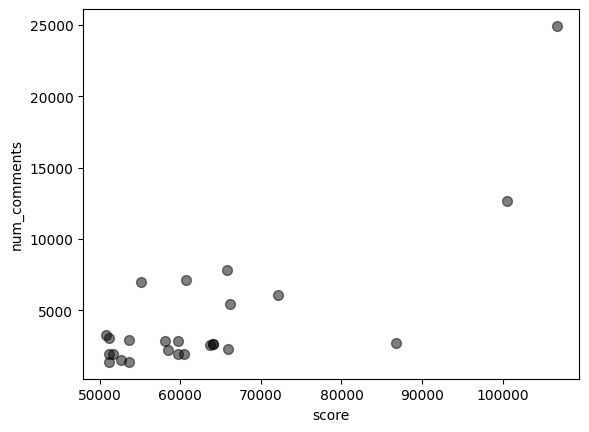

In [21]:
ax = top25_df.plot.scatter(x='score',y='num_comments',s=50,c='k',alpha=.5)
# ax.set_xlim((0,200000))
# ax.set_ylim((0,16000))

### Comments

This is a simple Reddit submission: [Where do you source your data?](https://www.reddit.com/r/datasets/comments/1ji7rlx/where_do_you_source_your_data_frustrated_with/). We can inspect the comments in this simple submission.

[Documentation for Comment model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/comment.html).

In [22]:
source_data = r.submission(id='1ji7rlx')

print("This submission was made on {0}.".format(datetime.utcfromtimestamp(source_data.created_utc)))
print("There are {0:,} comments.".format(source_data.num_comments))

This submission was made on 2025-03-23 19:40:56.
There are 23 comments.


/tmp/ipykernel_563/1664875912.py:3: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print("This submission was made on {0}.".format(datetime.utcfromtimestamp(source_data.created_utc)))


We can inspect these comments, working from the [Comment Extraction and Parsing](https://praw.readthedocs.io/en/latest/tutorials/comments.html) tutorial in PRAW.

In [23]:
source_data.comments.replace_more(limit=None)

for comment in source_data.comments.list():
    print(comment.body)

Find an open access scientific journal which requires open data access and take your pick. eLife is one; PLoS is another (or rather, many!). There are some other repositories like flybase and wormbase which have a lot of data on a few organisms. Just be polite about how you access the data; they've been getting hammered with LLM crawlers recently.
Get a client.  You will need to validate your tech in the fuled, and your data sources sould be as real as possible tonget good results.  Experience from experts will be highly valueble to weed out bad ideas and focus on generating value.
That’s why I actually create my own datasets through the use of web scraping, and being good at it.
For example, my current client I am helping wants all American made bourbons. I went to the COLA registry, paid for some proxies, and got it myself.
Open source and they have an email list as well. Updated weekly.

Data-is-plural.com. 


I believe google also has a datasets search engine. https://datasetsearch

Each comment has a lot of metadata we can preserve.

In [24]:
source_data_comment_metadata = []

for comment in source_data.comments.list():
    if not comment.collapsed: # Skip collapsed/deleted comments
        d = {}
        d['id'] = comment.id
        d['parent_id'] = comment.parent_id
        d['body'] = comment.body
        d['depth'] = comment.depth
        d['edited'] = comment.edited
        d['score'] = comment.score
        d['date'] = datetime.utcfromtimestamp(comment.created_utc)
        d['submission_id'] = comment.submission.id
        d['submission_title'] = comment.submission.title
        d['subreddit'] = comment.subreddit.display_name
        if comment.author is not None:
            d['author'] = comment.author.name
        source_data_comment_metadata.append(d)

/tmp/ipykernel_563/283445546.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  d['date'] = datetime.utcfromtimestamp(comment.created_utc)


Convert to a DataFrame.

In [25]:
source_data_df = pd.DataFrame(source_data_comment_metadata)

# How long is the comment
source_data_df['comment_length'] = source_data_df['body'].str.len()

source_data_df.head()

,id,parent_id,body,depth,edited,score,date,submission_id,submission_title,subreddit,author,comment_length
0,mjd53c0,t3_1ji7rlx,Find an open access scientific journal which r...,0,False,8,2025-03-23 20:08:04,1ji7rlx,Where Do You Source Your Data? Frustrated with...,datasets,tunisia3507,349
1,mjeaal8,t3_1ji7rlx,Get a client. You will need to validate your ...,0,False,3,2025-03-23 23:49:53,1ji7rlx,Where Do You Source Your Data? Frustrated with...,datasets,peyronet,238
2,mjhl78q,t3_1ji7rlx,That’s why I actually create my own datasets t...,0,False,2,2025-03-24 15:03:57,1ji7rlx,Where Do You Source Your Data? Frustrated with...,datasets,akindea,248
3,mjlu09x,t3_1ji7rlx,Open source and they have an email list as wel...,0,False,2,2025-03-25 04:43:19,1ji7rlx,Where Do You Source Your Data? Frustrated with...,datasets,1purenoiz,183
4,mjgyckq,t3_1ji7rlx,"I really feel your pain on this. Finding good,...",0,False,2,2025-03-24 12:56:42,1ji7rlx,Where Do You Source Your Data? Frustrated with...,datasets,StandUpDude,3417


Do comments deeper in this comment tree have lower scores?

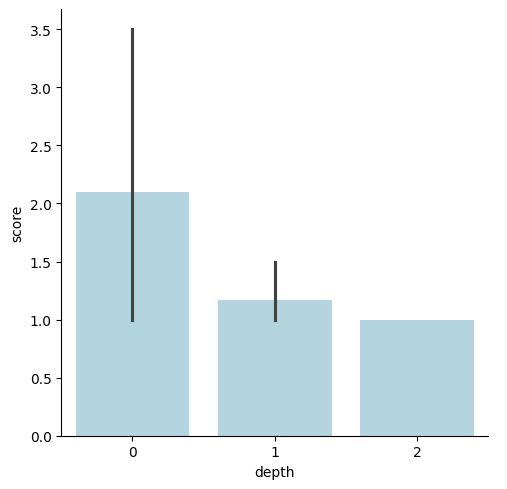

In [26]:
sb.catplot(x='depth',y='score',data=source_data_df,kind='bar',color='lightblue')

Do comments deeper in this comment tree have shorter lengths?

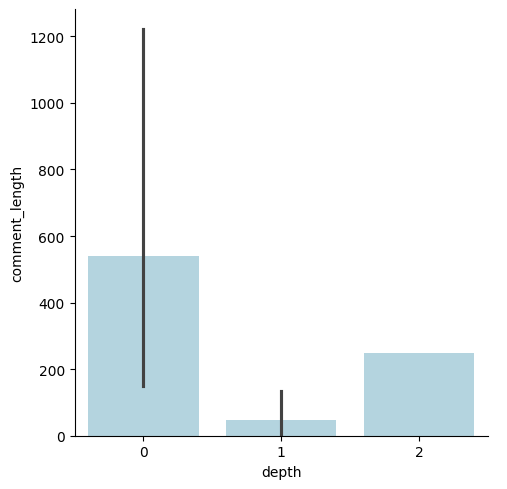

In [27]:
sb.catplot(x='depth',y='comment_length',data=source_data_df,kind='bar',color='lightblue')

### Redditors

A Redditor is a user and we can get meta-data about the account as well as the history of the user's comments and submissions from the API.

[Documentation for the Redditor model in PRAW](https://praw.readthedocs.io/en/latest/code_overview/models/redditor.html).

How much link and comment karma does this user have?

In [28]:
spez = r.redditor('spez')
print("Link karma: {0:,}".format(spez.link_karma))
print("Comment karma: {0:,}".format(spez.comment_karma))

Link karma: 178,142
Comment karma: 751,625


Interestingly, Reddit flags the users who are employees of Reddit as well as if accounts have verified email addresses.

In [29]:
spez.is_employee

True

In [30]:
spez.has_verified_email

True

We can also get the time this user's account was created.

In [31]:
datetime.utcfromtimestamp(spez.created_utc)

/tmp/ipykernel_563/2511850572.py:1: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  datetime.utcfromtimestamp(spez.created_utc)


datetime.datetime(2005, 6, 6, 4, 0)

We can also get information about individual redditors' submissions and comment histories. Here we will use u/spez (the CEO of Reddit), get his top-voted submissions, and loop through them to get the data for each submission.

In [32]:
spez_submissions = []

for submission in r.redditor('spez').submissions.top(time_filter='all',limit=25):
    d = {}
    d['id'] = submission.id
    d['title'] = submission.title
    d['num_comments'] = submission.num_comments
    d['score'] = submission.score
    d['upvote_ratio'] = submission.upvote_ratio
    d['date'] = datetime.utcfromtimestamp(submission.created_utc)
    d['domain'] = submission.domain
    d['gilded'] = submission.gilded
    d['num_crossposts'] = submission.num_crossposts
    d['nsfw'] = submission.over_18
    if comment.author is not None:
        d['author'] = submission.author.name
    spez_submissions.append(d)

/tmp/ipykernel_563/136595837.py:10: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  d['date'] = datetime.utcfromtimestamp(submission.created_utc)


Again we can turn this list of dictionaries into a DataFrame to do substantive data analysis.

In [33]:
pd.DataFrame(spez_submissions).head()

,id,title,num_comments,score,upvote_ratio,date,domain,gilded,num_crossposts,nsfw,author
0,7jsyqt,"The FCC’s vote was predictably frustrating, bu...",14476,194096,0.86,2017-12-14 17:10:15,self.announcements,8,28,False,spez
1,mcisdf,An update on the recent issues surrounding a R...,35901,107364,0.63,2021-03-24 22:37:47,self.announcements,10,147,False,spez
2,7fx1x4,An update on the fight for the free and open i...,7664,92815,0.81,2017-11-27 18:03:30,self.blog,4,20,False,spez
3,5frg1n,TIFU by editing some comments and creating an ...,34800,50316,0.61,2016-11-30 19:04:49,self.announcements,32,1,False,spez
4,3cxedn,"I am Steve Huffman, the new CEO of reddit. AMA.",12550,41372,0.83,2015-07-11 17:02:59,self.IAmA,2,1,False,spez


We can also get all the comments made by an editor.

In [34]:
spez_comments = []

for comment in r.redditor('spez').comments.top(time_filter = 'all',limit=25):
    d = {}
    d['id'] = comment.id
    d['body'] = comment.body
    try:
        d['depth'] = comment.depth
    except:
        d['depth'] = np.nan
    d['edited'] = comment.edited
    d['score'] = comment.score
    d['date'] = datetime.utcfromtimestamp(comment.created_utc)
    d['submission_id'] = comment.submission.id
    d['submission_title'] = comment.submission.title
    d['subreddit'] = comment.subreddit.display_name
    if comment.author is not None:
        d['author'] = comment.author.name
    spez_comments.append(d)

/tmp/ipykernel_563/3442959793.py:13: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  d['date'] = datetime.utcfromtimestamp(comment.created_utc)


In [35]:
pd.DataFrame(spez_comments).head()

,id,body,depth,edited,score,date,submission_id,submission_title,subreddit,author
0,d992fwq,Reddit search might work by then.,NaN,False,22197,2016-10-26 21:07:22,59k22p,"Hey, it’s Reddit’s totally politically neutral...",announcements,spez
1,dr95e2i,No. We don’t negotiate with terrorists.,NaN,False,20219,2017-12-14 19:33:42,7jsyqt,"The FCC’s vote was predictably frustrating, bu...",announcements,spez
2,dr8whnr,good bot,NaN,False,17494,2017-12-14 17:11:41,7jsyqt,"The FCC’s vote was predictably frustrating, bu...",announcements,spez
3,d992soe,On Reddit.,NaN,False,13841,2016-10-26 21:14:49,59k22p,"Hey, it’s Reddit’s totally politically neutral...",announcements,spez
4,damgw92,"> However, why not allow a small 5 minute wind...",NaN,False,12702,2016-11-30 19:40:47,5frg1n,TIFU by editing some comments and creating an ...,announcements,spez


This user's top comments are mostly focused in the /r/announcements subreddit.

In [36]:
pd.DataFrame(spez_comments)['subreddit'].value_counts()

subreddit
announcements    21
IAmA              2
blog              1
RoastMe           1
Name: count, dtype: int64

### Archived data via PushShift

#### As of 2 years ago Reddit changed their terms of service and this is no longer an accessible API. 

PushShift is a researcher-maintained archive of Reddit posts and comments. Full data dumps of [submissions](https://files.pushshift.io/reddit/submissions/) and [comments](https://files.pushshift.io/reddit/comments/) are available, although these are (unsurprisingly) very space intensive. You can also access an API to make [ElasticSearch](https://www.elastic.co/elasticsearch/) queries against a database of this archive of submissions and comments. Unfortunately, the service is frequently down. 

We will use the [`pmaw`](https://github.com/mattpodolak/pmaw) library to access this data endpoint using Python. Install `pmaw` once:

In [37]:
! pip install pmaw

  Using cached pmaw-3.0.0-py3-none-any.whl.metadata (25 kB)
Using cached pmaw-3.0.0-py3-none-any.whl (29 kB)


Load up the `PushshiftAPI` class from `psaw`.

In [38]:
from pmaw import PushshiftAPI

api = PushshiftAPI()

Retrieve the submission history for a subreddit.

In [39]:
submissions = api.search_submissions(subreddit="science",limit=1000)

submissions_list = [p for p in submissions]

len(submissions_list)

Not all PushShift shards are active. Query results may be incomplete.


0